In [1]:
import os
from os.path import join as ospj
import time
from time import gmtime, strftime
import datetime
from munch import Munch
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from collections import deque

from network.model_z import build_model
from core.checkpoint import CheckpointIO
from dataset.frame_dataset import FramesDataset, MotionDataset, DatasetRepeater
import network.utils as utils
import yaml
import random
from utils import Bar, Logger, AverageMeter, center
from tqdm import tqdm
from torch.nn.parallel.data_parallel import DataParallel
import pytorch_ssim
from torchsummary import summary
from torchvision import transforms
from tps.rand_tps import RandTPS
from network.vgg import VGG
import imp
from network.wing import FAN, HighPass

import warnings
warnings.filterwarnings("ignore")
import imageio

In [2]:
with open('config/train_transformer5.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = Munch(config)

In [3]:
# GPU Device
gpu_id = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
use_cuda = torch.cuda.is_available()
print("GPU device " , use_cuda)

GPU device  True


In [4]:
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
np.random.seed(config.seed)

In [5]:
resume = False

In [6]:
class Solver(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.args.lr = float(self.args.lr)
        self.args.weight_decay = float(self.args.weight_decay)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.start = 10
        self.replay_memory = 10000
        self.replay_buffer = deque(maxlen=self.replay_memory)

        self.nets, self.nets_ema = build_model(args)
        # below setattrs are to make networks be children of Solver, e.g., for self.to(self.device)
        for name, module in self.nets.items():
            utils.print_network(module, name)
            setattr(self, name, module)
        for name, module in self.nets_ema.items():
            setattr(self, name + '_ema', module)

        if args.mode == 'train':
            self.optims = Munch()
            for net in self.nets.keys():
                self.optims[net] = torch.optim.Adam(params=self.nets[net].parameters(), lr=float(args.lr), betas=[args.beta1, args.beta2],
                                                   weight_decay=0)

            self.ckptios = [
                CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets.ckpt'), **self.nets),
                CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets_ema.ckpt'), **self.nets_ema),
                CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_optims.ckpt'), **self.optims)]
        else:
            self.ckptios = [CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets_ema.ckpt'), **self.nets_ema)]
    

        self.to(self.device)
        for name, network in self.named_children():
            # Do not initialize the FAN parameters
            if ('ema' not in name) and ('fan' not in name):
                print('Initializing %s...' % name)
                network.apply(utils.he_init)
        
        # landmark
        self.fan = FAN(fname_pretrained=config.fname_fan)
        self.fan.to(self.device)
        self.fan.eval()
        self.hpf = HighPass(config.w_hpf, self.device)
        self.masking = transforms.RandomErasing(p=1.0, scale=(0.30, 0.33), ratio=(0.3, 0.33))
        self.clip_num = config.clip_num
        
        # eqv
        self.eqv_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=config.brightness, contrast=config.contrast, saturation=config.saturation, hue=config.hue),
            transforms.ToTensor(),])
        self.interp = nn.Upsample(size=(config.img_size, config.img_size), mode='bilinear', align_corners=True)
        self.tps = RandTPS(width=config.img_size, height=config.img_size, batch_size=config.batch_size, sigma=config.sigma, 
                           border_padding=True, random_mirror=True, random_scale=(0.8, 1.1))
        self.tps.to(self.device)
        self.tps.eval()
        self.kl = nn.KLDivLoss().to(self.device)
        
        # perceptual loss
        self.vgg = VGG()
        MainModel = imp.load_source("MainModel", args.fname_ir)
        weight = torch.load(args.fname_vgg, map_location='cpu')
        self.vgg.load_state_dict(weight.state_dict(), strict=False)
        self.vgg.eval()
        self.vgg.to(self.device)
        

    def _save_checkpoint(self, step):
        for ckptio in self.ckptios:
            ckptio.save(step)

    def _load_checkpoint(self, step):
        for ckptio in self.ckptios:
            ckptio.load(step)

    def _reset_grad(self):
        for optim in self.optims.values():
            optim.zero_grad()
            
    @torch.no_grad()
    def evaluate(self, args, epoch, nets, loader):
        if not os.path.isdir(args.result_dir):
            os.makedirs(args.result_dir)
        result_target = os.path.join(args.result_dir, 'tar')
        result_gen = os.path.join(args.result_dir,'gen')
        if not os.path.isdir(result_target):
            os.makedirs(result_target)
        if not os.path.isdir(result_gen):
            os.makedirs(result_gen)
        
        bar = tqdm(total=len(loader), leave=False)
        ssim_meter, fid_meter = AverageMeter(), AverageMeter()
        for iteration, x in enumerate(loader):
            try:
                test_video = torch.tensor(np.concatenate(x['video'])) # (frame, c, w, h)
            except:
                continue
            num_frame = test_video.shape[0]
            k_frame = np.random.choice(num_frame-args.K, size=2, replace=False)
            source = test_video[[k_frame[0]]]
            target = test_video[[k_frame[1]]]
            source_out = nets.transformer(self.fan.get_landmark(source.to(self.device)), self.fan.get_landmark(target.to(self.device)))
            source_out = self.get_clip(source_out)
            source_gen = nets.generator(source.to(self.device), target.to(self.device), source_out.to(self.device))
            ssim = float(pytorch_ssim.ssim(source_gen, target.to(self.device)))
            ssim_meter.update(ssim, iteration+1)
            
            # save for FID
            gen = source_gen.squeeze().cpu().detach().numpy()
            target = target.squeeze().cpu().detach().numpy()
            gen = gen.swapaxes(0, 1).swapaxes(1, 2)
            target = target.swapaxes(0, 1).swapaxes(1, 2)
            gen_img = Image.fromarray((gen*255).astype('uint8'))
            tar_img = Image.fromarray((target*255).astype('uint8'))
            gen_img.save(result_gen + '/{}.png'.format(iteration+1))
            tar_img.save(result_target + '/{}.png'.format(iteration+1))
            
            bar.set_description("Epoch:{:d}, SSIM: {:.8f}".format(epoch+1, ssim_meter.avg), refresh=True)
            bar.update()
        bar.close()
        val_logger.append([str(ssim_meter.avg)])
        return
    
    @torch.no_grad()
    def make_animation(self, args, nets, loaders):
        if not os.path.isdir(args.sample_dir):
            os.makedirs(args.sample_dir)
        K = 100
        random_list = np.random.choice(len(loaders.val.dataset), replace=False, size=2)
        source_image_idx = int(random_list[0])
        test_video_idx = int(random_list[1])
        train_video_idx = int(np.random.choice(len(loaders.src.dataset), size=1))
        # test animation
        source_image = loaders.val.dataset[source_image_idx]['video'][0]
        test_video = loaders.val.dataset[test_video_idx]['video'] # list [video](3, 256, 256)
        train_video = loaders.src.dataset[train_video_idx]['target'] # list [K](3, 256, 256)
        test_frame = len(test_video) if len(test_video) < K else K
        train_frame = len(train_video)
        predict_test, predict_train = [], []
        for i in range(test_frame):
            out = nets.transformer(self.fan.get_landmark(source_image.to(self.device).unsqueeze(0)), 
                                   self.fan.get_landmark(test_video[i].to(self.device).unsqueeze(0)))
            out = self.get_clip(out)
            gen = nets.generator(source_image.to(self.device).unsqueeze(0), test_video[i].to(self.device).unsqueeze(0), out.to(self.device))
            predict_test.append(gen.cpu().detach().numpy().squeeze().swapaxes(0, 1).swapaxes(1,2))
        
        for i in range(train_frame):
            out = nets.transformer(self.fan.get_landmark(source_image.to(self.device).unsqueeze(0)), 
                                   self.fan.get_landmark(train_video[i].to(self.device).unsqueeze(0)))
            out = self.get_clip(out)
            gen  = nets.generator(source_image.to(self.device).unsqueeze(0), train_video[i].to(self.device).unsqueeze(0), out.to(self.device))
            predict_train.append(gen.cpu().detach().numpy().squeeze().swapaxes(0,1).swapaxes(1,2))
        self.predict_test = predict_test
        source_image = (source_image*255).numpy().swapaxes(0,1).swapaxes(1,2).astype('uint8')
        source_img = Image.fromarray(source_image)
        source_img.save(config.sample_dir+ '/source.png')
        imageio.mimsave(os.path.join(config.sample_dir, 'test_gen.mp4'), [(frame*255).astype('uint8') for frame in predict_test], fps=24)
        imageio.mimsave(os.path.join(config.sample_dir, 'test_raw.mp4'), [(frame*255).numpy().astype('uint8').swapaxes(0,1).swapaxes(1,2) for frame in test_video], fps=24)
        imageio.mimsave(os.path.join(config.sample_dir, 'train_gen.mp4'), [(frame*255).astype('uint8') for frame in predict_train], fps=24)
        imageio.mimsave(os.path.join(config.sample_dir, 'train_raw.mp4'), [(frame*255).numpy().astype('uint8').swapaxes(0,1).swapaxes(1,2) for frame in train_video], fps=24)
    
    def get_clip(self, out):
        out[out < self.clip_num] = 0.
        return out
        
    
    def train(self, loaders):
        args = self.args
        nets = self.nets
        nets_ema = self.nets_ema
        
        for name in nets:
            nets[name] = DataParallel(nets[name])
            nets[name] = nets[name].to(self.device)
        optims = self.optims

        # resume training if necessary
        if args.resume_iter > 0:
            self._load_checkpoint(args.resume_iter)

        # batch
        for epoch in range(args.resume_iter, args.epochs):
            bar = tqdm(total=len(loaders.src)*args.K, leave=False)
            tf_loss, eqv_loss, center_loss = AverageMeter(), AverageMeter(), AverageMeter()
            wgan_loss, d_reg_loss = AverageMeter(), AverageMeter()
            g_latent_loss, g_cycle_loss, vgg_loss, fm_loss = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
            for i, inputs in enumerate(loaders.src):
                x_source, y_drive = inputs['source'], inputs['target']
                num_frame = len(y_drive)
                for f in range(num_frame):
                    self.replay_buffer.append((x_source, y_drive[f]))
                    
                    if len(self.replay_buffer) < self.start:
                        continue
                    minibatch = random.sample(self.replay_buffer, 1)
                    x_source_mb, y_drive_mb = minibatch[0][0], minibatch[0][1]
                    
                    # train the transformer
                    x_out, tf_losses, tf_losses_latent = compute_tf_loss(nets, args, x_source_mb, y_drive_mb,
                                                                         transform=self.eqv_transform, tps=self.tps, interp=self.interp, 
                                                                         kl=self.kl, fan=self.fan, mask=self.masking,
                                                                         device=self.device)

                    self._reset_grad()
                    tf_losses.backward()
                    optims.transformer.step()
                    
                    # train the discriminator
                    d_loss, d_losses_latent = compute_d_loss(nets, args, x_source_mb, y_drive_mb, x_out, device=self.device)
                    self._reset_grad()
                    d_loss.backward()
                    optims.discriminator.step()

                    # train the generator
                    g_loss, g_losses_latent = compute_g_loss(nets, args, x_source_mb, y_drive_mb, x_out, vgg=self.vgg, 
                                                             fan=self.fan, device=self.device)
                    self._reset_grad()
                    g_loss.backward()
                    optims.generator.step()

                    wgan_loss.update(float(d_losses_latent.wgangp), x_source.size(0))
                    d_reg_loss.update(float(d_losses_latent.reg), x_source.size(0))
                    g_latent_loss.update(float(g_losses_latent.adv), x_source.size(0))
                    g_cycle_loss.update(float(g_losses_latent.cyc), x_source.size(0))
                    vgg_loss.update(float(g_losses_latent.vgg), x_source.size(0))
                    fm_loss.update(float(g_losses_latent.fm), x_source.size(0))
                    tf_loss.update(float(tf_losses_latent.tf), x_source.size(0))
                    eqv_loss.update(float(tf_losses_latent.eqv), x_source.size(0))
                    center_loss.update(float(tf_losses_latent.center), x_source.size(0))

                    bar.set_description("Ep:{:d}, D: {:.6f}, R1: {:.2f}, G: {:.6f}, Cyc: {:.6f}, Vgg: {:.6f}, FM: {:.6f}, TF: {:.6f}, Eqv: {:.6f}, Ct: {:.6f}".format(
                                        epoch+1, wgan_loss.avg, d_reg_loss.avg, 
                                        g_latent_loss.avg, g_cycle_loss.avg, vgg_loss.avg, fm_loss.avg,
                                        tf_loss.avg, eqv_loss.avg, center_loss.avg), refresh=True)
                    bar.update()
            bar.close()

                # save model checkpoints
            logger.append([str(wgan_loss.avg)[:8], str(d_reg_loss.avg)[:8], 
                           str(g_latent_loss.avg)[:8], str(g_cycle_loss.avg)[:8], str(vgg_loss.avg)[:8], str(fm_loss.avg)[:8],
                           str(tf_loss.avg)[:8], str(eqv_loss.avg)[:8], str(center_loss.avg)[:8]])
            if (epoch+1) % config.save_every == 0:
                self._save_checkpoint(step=epoch+1)

            # compute SSIM and FID in test_set
            if (epoch+1) % config.eval_every == 0:
                self.evaluate(args, epoch, nets, loaders.val)
                
            self.make_animation(args, nets, loaders)
        
        self.evaluate(args, epoch, nets, loaders.val)

In [7]:
def compute_tf_loss(nets, args, x_real, y_org, transform, tps, interp, kl, fan, mask, device='cuda'):
    # TF_loss
    l2_loss = nn.MSELoss()
    x_real, y_org = x_real.to(device), y_org.to(device)
    x_landmark, y_landmark = fan.get_landmark(x_real), fan.get_landmark(y_org)
    y_landmark_masked = mask(y_landmark)
    x_out = nets.transformer(x_landmark, y_landmark_masked)
    loss_tf = l2_loss(x_out, y_landmark)
    
    # Equivariance loss
    # real --> transform(color / tps) --> gen
    softmax = nn.Softmax(dim=1)
    images_cj = x_landmark
    for b in range(images_cj.shape[0]):
        images_cj[b] = transform(images_cj[b])*255.0
    tps.reset_control_points()
    images_tps = tps(images_cj)
    pred_tps =  nets.transformer((images_tps/255.0), y_landmark_masked)
    pred_tps = interp(pred_tps)
    # real --> gen --> transform(tps)
    pred_d = x_out
    pred_d.requires_grad = False
    pred_tps_org = tps(pred_d, padding_mode='zeros')
    # Center: first center - second center
    centers_tps = center.batch_get_centers(softmax(pred_tps)[:, 1:, :, :])
    pred_tps_gen = tps(x_out, padding_mode='zeros')
    centers_tps_gen = center.batch_get_centers(softmax(pred_tps_gen)[:, 1:, :, :])
    
    # KL (first, second) / Center mse (first, second)
    loss_eqv = kl(F.log_softmax(pred_tps, dim=1), F.softmax(pred_tps_org))
    loss_center = F.mse_loss(centers_tps, centers_tps_gen)
    loss = loss_tf * args.lambda_tf + loss_eqv * args.lambda_eqv + loss_center * args.lambda_eqv
    return x_out, loss, Munch(tf=loss_tf.item(), eqv=loss_eqv.item(), center=loss_center.item())

def compute_d_loss(nets, args, x_real, y_org, x_out, device='cuda'):
#     assert (z_trg is None) != (x_ref is None)
    # with real images
    x_real, y_org, x_out = x_real.to(device), y_org.to(device), x_out.to(device)
    x_real.requires_grad = True
    real_out = nets.discriminator(x_real)
    loss_real = adv_loss(real_out, 1)
    # R1-reg
    loss_reg = r1_reg(real_out, x_real)
     # with fake images
    with torch.no_grad():
        x_fake = nets.generator(x_real, y_org, x_out)
    fake_out = nets.discriminator(x_fake)
    loss_fake = adv_loss(fake_out, 0)
    loss = loss_real + loss_fake + args.lambda_reg * loss_reg
    return loss, Munch(wgangp=loss_real.item()+loss_fake.item(), reg=loss_reg.item())


def compute_g_loss(nets, args, x_real, y_org, x_out, vgg, fan, device='cuda'):
    # adversarial loss
    x_real, y_org, x_out= x_real.to(device), y_org.to(device), x_out.to(device)
    x_fake = nets.generator(x_real, y_org, x_out)
    out = nets.discriminator(x_fake)
    # adv loss
    loss_adv = adv_loss(out, 1)
    
    # cycle-consistency loss
    x_fake_landmark = fan.get_landmark(x_fake)
    x_real_landmark = fan.get_landmark(x_real)
    x_fake_out = nets.transformer(x_fake_landmark, x_real_landmark)
    x_rec = nets.generator(x_fake, x_real, x_fake_out)
    loss_cyc = torch.mean(torch.abs(x_rec - x_real))
    
    # perceptual loss
    l1_loss = nn.L1Loss()
    with torch.no_grad():
        vgg_x = vgg(x_real)
    with torch.autograd.enable_grad():
        vgg_xhat = vgg(x_fake)
        
    loss_vgg = 0
    for x_feat, xhat_feat in zip(vgg_x, vgg_xhat):
        loss_vgg += l1_loss(x_feat, xhat_feat)
        
    # feature-matching loss
    loss_fm = l1_loss(x_out, x_fake_landmark)

    loss = loss_adv + args.lambda_cyc * loss_cyc + args.lambda_vgg * loss_vgg + args.lambda_fm * loss_fm
    return loss, Munch(adv=loss_adv.item(), cyc=loss_cyc.item(), vgg=loss_vgg.item(), fm=loss_fm.item())
    

def gradient_penalty(nets, real, fake, reg_lambda=10, device='cuda'):
    from torch.autograd import grad
    batch_size = real.shape[0]
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
    merged = (epsilon * real) + ((1 - epsilon) * fake)
    # forward
    op = nets.discriminator(merged)
    
    # merted gradient
    gradient = grad(outputs=op, inputs=merged, create_graph=True, grad_outputs=torch.ones_like(op), 
                    retain_graph=True, only_inputs=True)[0]
    
    # calc penalty
    penalty = reg_lambda * ((gradient.norm(p=2, dim=1) - 1) ** 2).mean()
    return penalty
    

def moving_average(model, model_test, beta=0.999):
    for param, param_test in zip(model.parameters(), model_test.parameters()):
        param_test.data = torch.lerp(param.data, param_test.data, beta)


def adv_loss(logits, target):
    assert target in [1, 0]
    targets = torch.full_like(logits, fill_value=target)
    loss = F.binary_cross_entropy_with_logits(logits, targets)
    return loss


def r1_reg(d_out, x_in):
    # zero-centered gradient penalty for real images
    batch_size = x_in.size(0)
    grad_dout = torch.autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_dout2 = grad_dout.pow(2)
    assert(grad_dout2.size() == x_in.size())
    reg = 0.5 * grad_dout2.view(batch_size, -1).sum(1).mean(0)
    return reg

In [8]:
train_dataset = MotionDataset(config.root_dir, image_shape=config.frame_shape, id_sampling=True, is_train=True, random_seed=config.seed)
test_dataset = FramesDataset(config.root_dir, image_shape=config.frame_shape, id_sampling=True, is_train=False, random_seed=config.seed)

Use predefined train-test split.
Use predefined train-test split.


In [9]:
# train_dataset = DatasetRepeater(train_dataset, config.num_repeats)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, 
                              num_workers=config.num_workers, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=config.num_workers)

In [11]:
loaders = Munch(src=train_loader, val=test_loader)

In [12]:
solver = Solver(config)

Number of parameters of generator: 42362883
Number of parameters of discriminator: 20851777
Number of parameters of transformer: 7362049
Initializing generator...
Initializing discriminator...
Initializing transformer...


In [13]:
solver._load_checkpoint(4)

Loading checkpoint from logs/tf5/checkpoints/000004_nets.ckpt...
Loading checkpoint from logs/tf5/checkpoints/000004_nets_ema.ckpt...
Loading checkpoint from logs/tf5/checkpoints/000004_optims.ckpt...


In [14]:
for i in train_loader:
    break

In [15]:
for j in test_loader:
    break

In [16]:
source = i['source'][[5]]
target = i['target'][5][[5]]

In [17]:
video = j['video']

In [18]:
import matplotlib.pyplot as plt

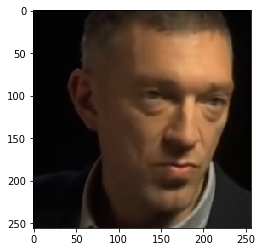

In [19]:
plt.imshow(source.cpu().squeeze().numpy().swapaxes(0,1).swapaxes(1,2))

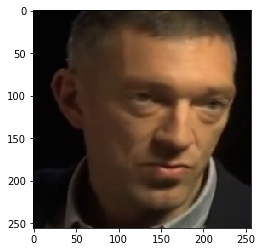

In [20]:
plt.imshow(target.cpu().squeeze().numpy().swapaxes(0,1).swapaxes(1,2))

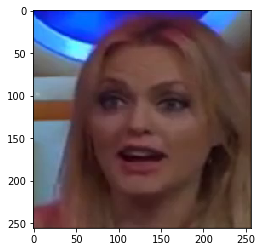

In [21]:
plt.imshow(video[0].cpu().squeeze().numpy().swapaxes(0,1).swapaxes(1,2))

In [22]:
source_land = solver.fan.get_landmark(source.cuda())
target_land = solver.fan.get_landmark(target.cuda())
test_land = solver.fan.get_landmark(video[0].cuda())

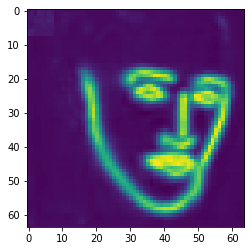

In [23]:
plt.imshow(source_land.cpu().squeeze())

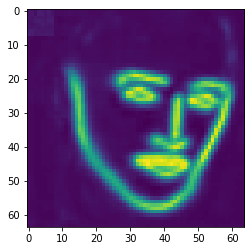

In [24]:
plt.imshow(target_land.cpu().squeeze())

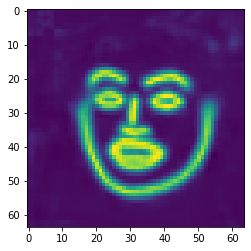

In [25]:
plt.imshow(test_land.cpu().squeeze())

In [26]:
t = solver.nets.transformer(source_land, target_land)

In [43]:
t_test = solver.nets.transformer(test_land, target_land)

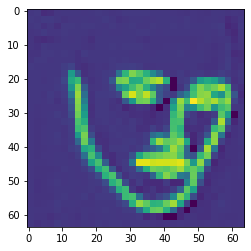

In [44]:
plt.imshow(solver.get_clip(t).cpu().detach().numpy().squeeze())

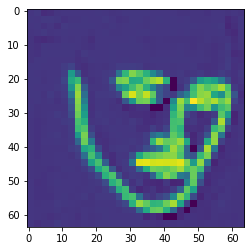

In [45]:
plt.imshow(solver.get_clip(t_test).cpu().detach().numpy().squeeze())

In [46]:
out = solver.generator(video[0].cuda(), target.cuda(), solver.get_clip(t_test))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


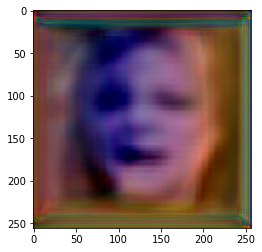

In [47]:
plt.imshow(out.cpu().detach().squeeze().numpy().swapaxes(0,1).swapaxes(1,2))

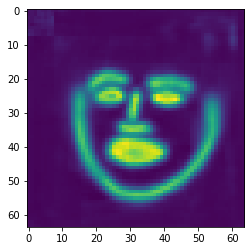

In [32]:
plt.imshow(solver.fan.get_landmark(out).cpu().numpy().squeeze())

In [33]:
slice_idx = [0,
                512*4, #res1
                512*4, #res2
                512*4, #res3
                512*4, #res4
                512*4, #res5
                512*2 + 256*2, #resUp1
                256*2 + 128*2, #resUp2
                128*2 + 64*2, #resUp3
                64*2 + 32*2, #resUp4
                32*2] #last adain
for i in range(1, len(slice_idx)):
    slice_idx[i] = slice_idx[i-1] + slice_idx[i]

In [34]:
slice_idx

[0, 2048, 4096, 6144, 8192, 10240, 11776, 12544, 12928, 13120, 13184]

In [35]:
P_LEN = 2*(512*2*5 + 512+256 + 256+128 + 128+64 + 64+32 + 32)

In [36]:
P_LEN

13184

In [37]:
p = nn.Parameter(torch.rand(13184, 512).normal_(0.0, 0.01))

In [38]:
psi = nn.Parameter(torch.rand(13184, 1))

In [39]:
e = nn.Parameter(torch.rand(1, 512, 1))

In [40]:
p = p.unsqueeze(0)

In [41]:
e_psi = torch.bmm(p, e)

In [1]:
test = torch.Tensor(np.random.normal(size=(1, 64, 64, 64)))

NameError: name 'torch' is not defined

In [42]:
slice_idx[0]:slice_idx[1]

In [92]:
int_land = F.interpolate(target_land, size=256, mode='bilinear')

In [93]:
int_land

tensor([[[[ 0.0296,  0.0296,  0.0296,  ...,  0.0024,  0.0032,  0.0032],
          [ 0.0296,  0.0296,  0.0296,  ...,  0.0024,  0.0032,  0.0032],
          [ 0.0291,  0.0291,  0.0293,  ...,  0.0020,  0.0028,  0.0028],
          ...,
          [ 0.0006,  0.0006,  0.0020,  ...,  0.0006,  0.0011,  0.0011],
          [-0.0009, -0.0009,  0.0006,  ...,  0.0010,  0.0015,  0.0015],
          [-0.0009, -0.0009,  0.0006,  ...,  0.0010,  0.0015,  0.0015]]]],
       device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


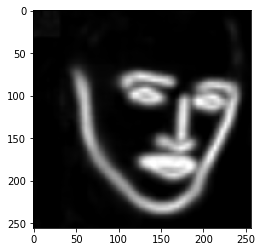

In [94]:
plt.imshow(int_land.repeat(1,3,1,1).cpu().detach().numpy().squeeze().swapaxes(0,1).swapaxes(1,2))

In [95]:
g = F.grid_sample(target.cuda(), int_land.permute(0,2,3,1).repeat(1,1,1,2))

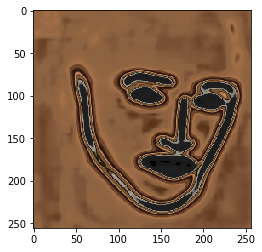

In [96]:
plt.imshow(g.cpu().detach().numpy().squeeze().swapaxes(0,1).swapaxes(1,2))

In [75]:
s_synthesized = source.cuda()+F.interpolate(source_land, size=256, mode='bilinear')

In [97]:
v = target.cuda() *g

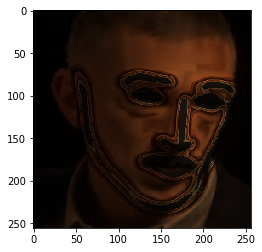

In [98]:
plt.imshow(v.cpu().detach().numpy().squeeze().swapaxes(0,1).swapaxes(1,2))

In [103]:
solver.nets.discriminator

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResBlk(
      (actv): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1x1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResBlk(
      (actv): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1x1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlk(
      (actv): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1x1): Conv2d(256, 512, kern

In [106]:
2**14 // 256

64